# Modelo clasificación de farmacos


----------------------------------------------------
----------------------------------------------------

### Predicting the drug a patient will require in the future

Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe a drug to a new patient.

DATA Source: IBM

From Kaggle:
https://www.kaggle.com/pablomgomez21/drugs-a-b-c-x-y-for-decision-trees

### Importing packages 

In [50]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
import seaborn as sns 
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.feature_selection import VarianceThreshold

import pickle
from collections import defaultdict
from datetime import datetime
from difflib import SequenceMatcher
from unidecode import unidecode
from nltk import download as nltkd
from nltk.corpus import stopwords 
from nltk.stem.porter import * 
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import coo_matrix
from sklearn.metrics import classification_report
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Importing dataset

In [2]:
data = pd.read_csv('drug200.csv')
data.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC


We convert the target in numeric values. 

In [4]:
data['Drug'].loc[data['Drug'] == 'drugY'] = 4
data['Drug'].loc[data['Drug'] == 'drugX'] = 3
data['Drug'].loc[data['Drug'] == 'drugA'] = 0
data['Drug'].loc[data['Drug'] == 'drugB'] = 1
data['Drug'].loc[data['Drug'] == 'drugC'] = 2

We can see how the distribution of the target variable is found, the drugY category is the one with the most values. Contains 45% of 100% securities, followed by drugX.

In [5]:
data['Drug'].value_counts(2)*100

4    45.5
3    27.0
0    11.5
2     8.0
1     8.0
Name: Drug, dtype: float64

<AxesSubplot:ylabel='Drug'>

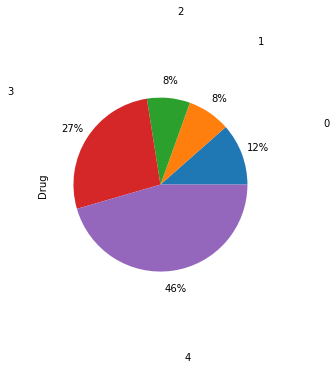

In [6]:
# Drug distribution
data['Drug'].value_counts().sort_index().plot.pie(autopct='%1.0f%%', pctdistance=1.2, labeldistance=2)

## Tipo de dato

With the data type we classify all the features of the dataset in order to carry out a more specific analysis.

In [8]:
NUMERIC = ['Na_to_K']
INTEGER = ['Age']
CATEGORICAL = ['Sex', 'BP', 'Cholesterol']

## Graphics 

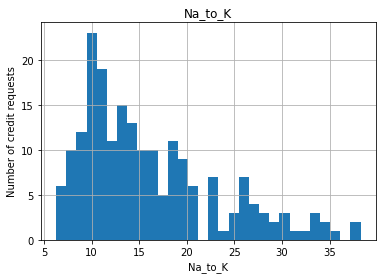

In [9]:
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of credit requests')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in NUMERIC:
    analyse_continuous(data, var)

In [10]:
data['Drug'] = data['Drug'].astype('int64')

Age


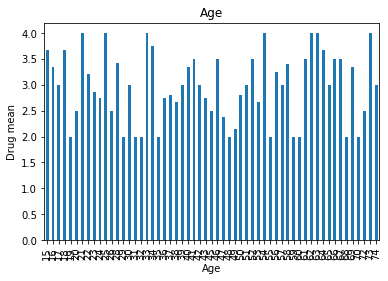

In [11]:
def analyse_discrete(df, var):
    print(var)
    df = df.copy()
    df = df.groupby(var)['Drug'].mean()
    if(len(df)>0):
        df = df.plot.bar()
        plt.title(var)
        plt.ylabel('Drug mean')
        plt.show()
    
for var in INTEGER:
    analyse_discrete(data, var)

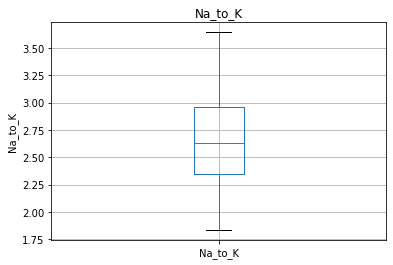

In [12]:
def find_outliers(df, var):
    df = df.copy()

    # log does not take negative values, so let's be
    # careful and skip those variables
    #if any(data[var] <= 0):
    #    pass
    #else:
    df[var] = np.log(df[var])
    df.boxplot(column=var)
    plt.title(var)
    plt.ylabel(var)
    plt.show()


for var in NUMERIC:
    find_outliers(data, var)

<AxesSubplot:>

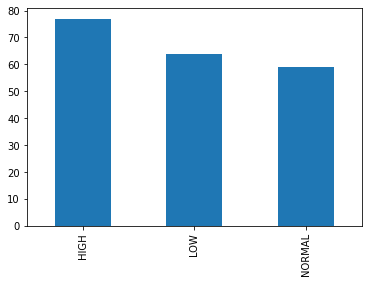

In [17]:
data['BP'].value_counts().plot(kind='bar')

<AxesSubplot:>

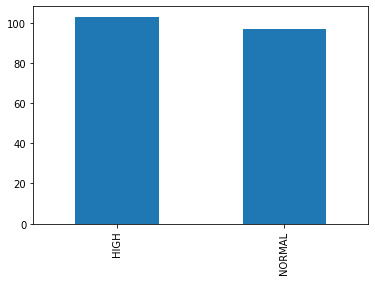

In [18]:
data['Cholesterol'].value_counts().plot(kind='bar')

## Missing values

In [19]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# determine percentage of missing values
missing = pd.DataFrame(data[vars_with_na].isnull().mean().sort_values(ascending=False), columns=['% Missing values'])
missing[missing['% Missing values']>=0.2]

,% Missing values


We can see that it has no missing value, so it is not necessary to replace any value, if they exist we replace it with the average.

## Cleaning categorical values

In this part we aim to clean up categorical variables, in case there is a possibility that they are misspelled and there are values with the same meanings but with a diversity of writing, so we convert all the values into lowercase and remove any sign of expression in that case. there would be. In our dataset we do not have any of these problems.

In [20]:
stemmer_es = SnowballStemmer("spanish") 
nltkd("stopwords") 
#stopwords = stopwords.words('spanish')

def CleaningCatecorical(text):
    text = text.astype(str).str.lower() # to lowercase
    text = text.apply(unidecode) # to  unicode
    text = text.str.replace("\(a\)", "") # remove gender tag (a)
    text = text.str.replace("ñ", "n") # remove gender tag (a)
    text = text.str.replace(r"[^a-z0-9]", " ") # remove symbols
    #text = re.sub("[^a-zA-Z]", " ", str(text))
    #text = ' '.join([word for word in text if word not in stopwords]) #Remove stopwords
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NancyGiron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
%%time
data[CATEGORICAL] = data[CATEGORICAL].fillna('tempnan').apply(lambda x: CleaningCatecorical(x)).replace('tempnan',np.nan)

Wall time: 8 ms


Of the three categorical variables in the dataset, they do not have many unique values, so we assume that the variables are well written. This in order to perform the one hot encoding method so that all variables are numeric.

In [22]:
df_cat_vars_stats = data[CATEGORICAL].describe(include='all', ).transpose().sort_values(by=['unique'], ascending=False)
df_cat_vars_stats['NaNs'] = round((1-df_cat_vars_stats['count']/data[CATEGORICAL].shape[0]).astype('float32'), 2)
df_cat_vars_stats

,count,unique,top,freq,NaNs
BP,200,3,high,77,0.0
Sex,200,2,m,104,0.0
Cholesterol,200,2,high,103,0.0


In [23]:
dummies = pd.get_dummies(data[CATEGORICAL])
data.drop(CATEGORICAL, axis=1, inplace= True)
data = pd.concat([dummies, data], axis=1)
one_hot_columns = list(data.columns)

In [24]:
data.head()

,Sex_f,Sex_m,BP_high,BP_low,BP_normal,Cholesterol_high,Cholesterol_normal,Age,Na_to_K,Drug
0,1,0,1,0,0,1,0,23,25.355,4
1,0,1,0,1,0,1,0,47,13.093,2
2,0,1,0,1,0,1,0,47,10.114,2
3,1,0,0,0,1,1,0,28,7.798,3
4,1,0,0,1,0,1,0,61,18.043,4


###  Outliers

In [25]:
def outliers(data, columns):   
    for column in columns:
        mask = (np.abs(stats.zscore(data[column])) > 2.33)
        data[column] = data[column].mask(mask).interpolate()
    return data

In [26]:
data = outliers(data, NUMERIC)

### Varianza

In this section, the predictor variables that do not have much variation in the value of their data will be eliminated, that is, they may contain a single value or predictors that only change some values.

VarianceThreshold is used from the sklearn library with which all variables with a variance less than 2% are eliminated, again we do this with X_train, we determine the columns with low variance and we eliminate them.

In [27]:
from sklearn.feature_selection import VarianceThreshold
threshold_n=0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
sel_var=sel.fit_transform(data)
data_var = data[data.columns[sel.get_support(indices=True)]] 

In [28]:
columns_x = list(data_var.columns)

In [29]:
data = data[columns_x]

In [30]:
data.head(2)

,Sex_f,Sex_m,BP_high,BP_low,BP_normal,Cholesterol_high,Cholesterol_normal,Age,Na_to_K,Drug
0,1,0,1,0,0,1,0,23,25.355,4
1,0,1,0,1,0,1,0,47,13.093,2


## Correlations

We determine all those columns that are correlated with each other since a high correlation could make the variables redundant since one describes the other quite well. We eliminate these variables and apply it again to the other data sets that are being worked, in this case data.

In [51]:
cor_matrix = data.corr().abs()

In [52]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

In [53]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)] 

In [55]:
columns_no_correlated = list(data.columns)
for drop in to_drop:
    columns_no_correlated.remove(drop)

Previously we found the correlation between the variables, now we find the correlation that we have with our target variable.

In [38]:
corr = data.corr()

In [46]:
corr.loc[np.abs(corr['Drug'])>=0.2]

,Sex_f,Sex_m,BP_high,BP_low,BP_normal,Cholesterol_high,Cholesterol_normal,Age,Na_to_K,Drug
BP_high,0.021390,-0.021390,1.000000,-0.542767,-0.511811,-0.095708,0.095708,-0.099782,0.095526,-0.397846
BP_normal,0.036868,-0.036868,-0.511811,-0.443749,1.000000,0.145118,-0.145118,-0.009025,-0.102437,0.245696
Na_to_K,0.139590,-0.139590,0.095526,0.000500,-0.102437,-0.010219,0.010219,-0.070686,1.000000,0.588391
Drug,0.098573,-0.098573,-0.397846,0.174805,0.245696,-0.055629,0.055629,-0.004828,0.588391,1.000000


## Split data

In [31]:
# Split data
X = data.drop('Drug', axis = 1)
y = data['Drug']
y  =y.astype('int')
np.random.seed(42)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [33]:
X_train.shape, X_test.shape

((140, 9), (60, 9))

In [34]:
robust = RobustScaler()
fitted_scaler = robust.fit(X_train)

In [35]:
X_train = fitted_scaler.transform(X_train)
X_test = fitted_scaler.transform(X_test)

###  Modelo RandomForest

A tuning is carried out with the hyperparameters of the Random Forest model, the chosen metric was the precision to be able to choose the best model.

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 10)]
max_depth.append(None)
bootstrap = [True]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]




rf_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = rf_grid, 
                          cv = 3, verbose = 2, scoring='accuracy')

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1980 candidates, totalling 5940 fits
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20, t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=1, max_features=auto

[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=1, max_features=auto

[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=1, max_featu

[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=a

[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=1, max_featu

[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=1, max_features=auto

[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=1, max_features=auto

[CV]  bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=1, max_features=sq

[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt

[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=1, max_featu

[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt

[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=1, max_featu

[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt

[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt,

[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=1, max_featu

[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=a

[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=3, max_featu

[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=3, max_features=auto

[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=3, max_features=auto

[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=3, max_featu

[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=3, max_features=a

[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=3, max_featu

[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt

[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt

[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_

[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt

[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=3, max_featu

[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt

[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=s

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=5, max_features=auto

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=5, max_features=auto

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=5, max_featu

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=5, max_features=auto

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_featu

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=5, max_features=auto

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=5, max_features=auto

[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=5, max_featu

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_features

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=5, max_featu

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_fea

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt

[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=5, max_featu

[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=7, max_features=a

[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=7, max_featu

[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=7, max_features=auto

[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=7, max_features=auto

[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=7, max_fea

[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=7, max_features=auto

[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=7, max_featu

[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt

[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=7, max_features=s

[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt

[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt

[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=7, max_featu

[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt

[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=7, max_featu

[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=9, max_features=auto

[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=9, max_features=auto

[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=9, max_featu

[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=9, max_features=a

[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=9, max_featu

[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=auto

[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=9, max_features=auto

[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_fe

[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt

[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=9, max_featu

[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt

[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt

[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=9, max_

[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt

[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=9, max_featu

[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=11, max_feat

[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=11, 

[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=11, max_feat

[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=11, max_feat

[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=11, 

[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=11, max

[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=11, 

[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=11, max_feat

[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_fea

[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=11, max_fe

[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=11, max_feat

[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=11, 

[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=11, max_feat

[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=11, m

[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=13, max_feat

[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=13, max_feat

[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=13, 

[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=13, max_f

[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=13, 

[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, max_feat

[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=13, max_feat

[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=13, 

[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=13, max_fea

[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=13, 

[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=13, max_feat

[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=13, max_feat

[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=1

[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=13, max_feat

[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=13, 

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_feat

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_feat

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=15

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_feat

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, 

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_feat

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=15, 

[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_feat

[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_feat

[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, 

[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max

[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=15, 

[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=15, max_feat

[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_feat

[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, 

[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=17, max_f

[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=17, 

[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=17, max_feat

[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=17, max_feat

[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth

[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=17, max_feat

[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=17, 

[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=17, max_feat

[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=17, max_feat

[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=17, max_fe

[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=17, max_feat

[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=17, 

[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=17, max_feat

[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=17, max

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, m

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap

[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_d

[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=70, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.0s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True

[Parallel(n_jobs=1)]: Done 5940 out of 5940 | elapsed:  5.6min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             scoring='accuracy', verbose=2)

In [47]:
y_pred = grid_search.predict(X_test)
target_names = ['0', '1', '2', '3', '4']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.67      0.80         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        19
           4       1.00      0.96      0.98        27

    accuracy                           0.95        60
   macro avg       0.91      0.93      0.90        60
weighted avg       0.97      0.95      0.95        60



We can observe the results of the model, the metrics for each of the classes to be predicted or the drugs that will be recommended.